In [4]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from IPython import display
import matplotlib.animation as animation
from datetime import datetime
from torch.optim.optimizer import Optimizer
import hamiltorch
import corner
import scipy

import sys
sys.path.append("..")
from src.datasets import SimpleRegressionDataset
from src.models import OneHiddenLayerFeedForwardNetwork
from src.utils import EarlyStopping, TrainOptimizerSGLD, LearningMachine


OPTIMISER_SWITCH = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD, 
}
def _generate_data(reg_func, n, xlims, sigma):
    X = torch.rand((n, 1)) * (xlims[1] - xlims[0]) + xlims[0]
    y = reg_func(X) + torch.randn_like(X) * sigma
    return X, y


def make_log_prob_func(model, loss_fn, X_train, y_train, inv_temp=1.0, device="cpu", epsilon=0.1):
    params_shape_list = []
    params_flattened_list = []
    tau_list = []
    tau_out=1.
    normalizing_const = 1.0
    
    center = hamiltorch.util.flatten(model).to(device).clone().detach()
    
    for weights in model.parameters():
        params_shape_list.append(weights.shape)
        params_flattened_list.append(weights.nelement())

    log_likelihood_func = hamiltorch.samplers.define_model_log_prob(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        params_flattened_list, 
        params_shape_list, 
        tau_list, 
        tau_out, 
        normalizing_const=normalizing_const,  
        device=device
    )
    
    def log_prior_func(params):
        return 0
        return torch.distributions.MultivariateNormal(center, 0.1 * torch.eye(len(center))).log_prob(params)

        sqdist = torch.sum((params - center)**2)
        dist = torch.sqrt(sqdist)
#         dist = torch.abs(params - center).max().item()
        if dist < epsilon:
            return 0
        else:
            return -5 # -10 * sqdist #2 * np.log(epsilon)
        
    
    def log_prob_func(param):
        return log_likelihood_func(param) * inv_temp + log_prior_func(param)
    
    return log_likelihood_func, log_prior_func, log_prob_func




In [2]:
device = "cpu"
ACTIVATION = lambda x: x

param_true = (0.5, 0.0)
regression_fn_true = OneHiddenLayerFeedForwardNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true, 
    activation=ACTIVATION
)

n = 1000
n_test = 100
H = 1
xlims = (-10, 10)
sigma = 0.1
X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)


train_dataset = SimpleRegressionDataset(X_train, y_train)
test_dataset = SimpleRegressionDataset(X_test, y_test)
loss_fn = nn.MSELoss()

model = OneHiddenLayerFeedForwardNetwork(
    H=H, 
    init_param=torch.tensor(param_true),
    activation=ACTIVATION
#     init_param=torch.zeros(2 * H)
)
machine = LearningMachine(
    model, 
    train_dataset,
    test_dataset, 
    loss_fn, 
    OPTIMISER_SWITCH["adam"](model.parameters(), lr=0.001), 
#     batch_size=batch_size,
    batch_fraction=0.2,
)
early_stopping = EarlyStopping(patience=5, epsilon=1e-4)
print("Training")
machine.training_loop(1000, stopping_condition=early_stopping.early_stopping_by_train_loss_improvement)
print("Done")
param_final = hamiltorch.util.flatten(machine.model).to(device).clone().detach()
print(f"final parameter: {param_final}")

/Users/edmund/Desktop/phd_research/projects/phases-in-singular-models/phase-transition-in-singular-model-paper/experiments/../src/models.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_dict[name] = torch.tensor(parameters[i], requires_grad=True).reshape(shape)


Training
Done
final parameter: tensor([ 0.2448, -0.0030])


In [3]:
params_init = hamiltorch.util.flatten(model).to(device).clone()
num_posterior_samples = 5000
step_size = 0.1
num_steps_per_sample = 10


itemps = [0.1, 0.5, 0.9]
# itemps = [2.0, 3.0, 4.0]
expt_recs = {}
for itemp in itemps: 
    print(itemp)
    log_likelihood_func, log_prior_func, log_prob_func = make_log_prob_func(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        inv_temp=itemp, 
        epsilon=0.1
    )
    #     log_likelihood_func = lambda x: -torch.prod(x ** torch.tensor([2.0, 4.0])) * itemp * n

    params_hmc = hamiltorch.sample(
        log_prob_func=log_likelihood_func, 
        params_init=params_init, 
        num_samples=num_posterior_samples,
        burn=0,
        sampler=hamiltorch.Sampler.HMC, 
        integrator=hamiltorch.Integrator.IMPLICIT, 
        metric=hamiltorch.Metric.SOFTABS, 
    #     fixed_point_threshold=1e-3, 
    #     jitter=0.01,
        num_steps_per_sample=num_steps_per_sample,
        step_size=step_size,
        softabs_const=10**6
    )
    expt_recs[itemp] = {
        "params": params_hmc, 
        "log_prob_func": log_prob_func, 
        "log_likelihood_func": log_likelihood_func,
        "log_prior_func": log_prior_func,
    }

0.1
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Invalid log_prob: -inf, params: tensor([-1.0711e+14,  2.6095e+13], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-1.2660e+28, -6.2834e+28], requires_grad=True)
Invalid log_prob: -inf, params: tensor([ 4.3510e+29, -1.6253e+29], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-8.0366e+08,  4.4329e+08], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, -inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, -inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-3.1162e+13,  4.7717e+13], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, inf], requires_grad=True)      
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf, -inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf, -inf], requires_grad=True)
Inval

Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)       
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf, -inf], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([1.2082e+22, 2.0224e+22], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, -inf], requires_grad

0d:00:00:05 | 0d:00:00:00 | #################### | 5000/5000 | 864.90       
Acceptance Rate 0.80
0.5
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Invalid log_prob: -inf, params: tensor([2.4936e+28, 3.1362e+28], requires_grad=True)
Invalid log_prob: -inf, params: tensor([1.5992e+24, 4.5207e+23], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-7.7538e+11, -2.7563e+11], requires_grad=True)
Invalid log_prob: -inf, params: tensor([1.8086e+08, 1.0544e+09], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, inf], requires_grad=True)      
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([ 2.7320e+26, -6.2720e+26], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-1.5372e+22, -6.6639e+21], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf,

Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([ 8.1907e+11, -2.4238e+12], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-1.8781e+23,  4.0563e+22], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-1.1997e+31, -9.6922e+31], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf, inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([1.7887e+13, 8.5357e+11], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf

Invalid log_prob: -inf, params: tensor([inf, -inf], requires_grad=True)     
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, -inf], requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-1.2135e+11, -7.6882e+09], requires_grad=True)
Invalid log_prob: -inf, params: tensor([5.5457e+33, 2.1567e+34], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf, -inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, -inf], requires_grad=True)
Invalid log_prob: nan, params: tensor([-inf, nan], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-inf, inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([-3.5467e+27,  4.5001e+26], requires_grad=True)
Invalid log_prob: -inf, params: tensor([inf, inf], requires_grad=True)
Invalid log_prob: -inf, params: tensor([4.1084e+16, 3.8636e+17], requires_grad=True)
Invalid 

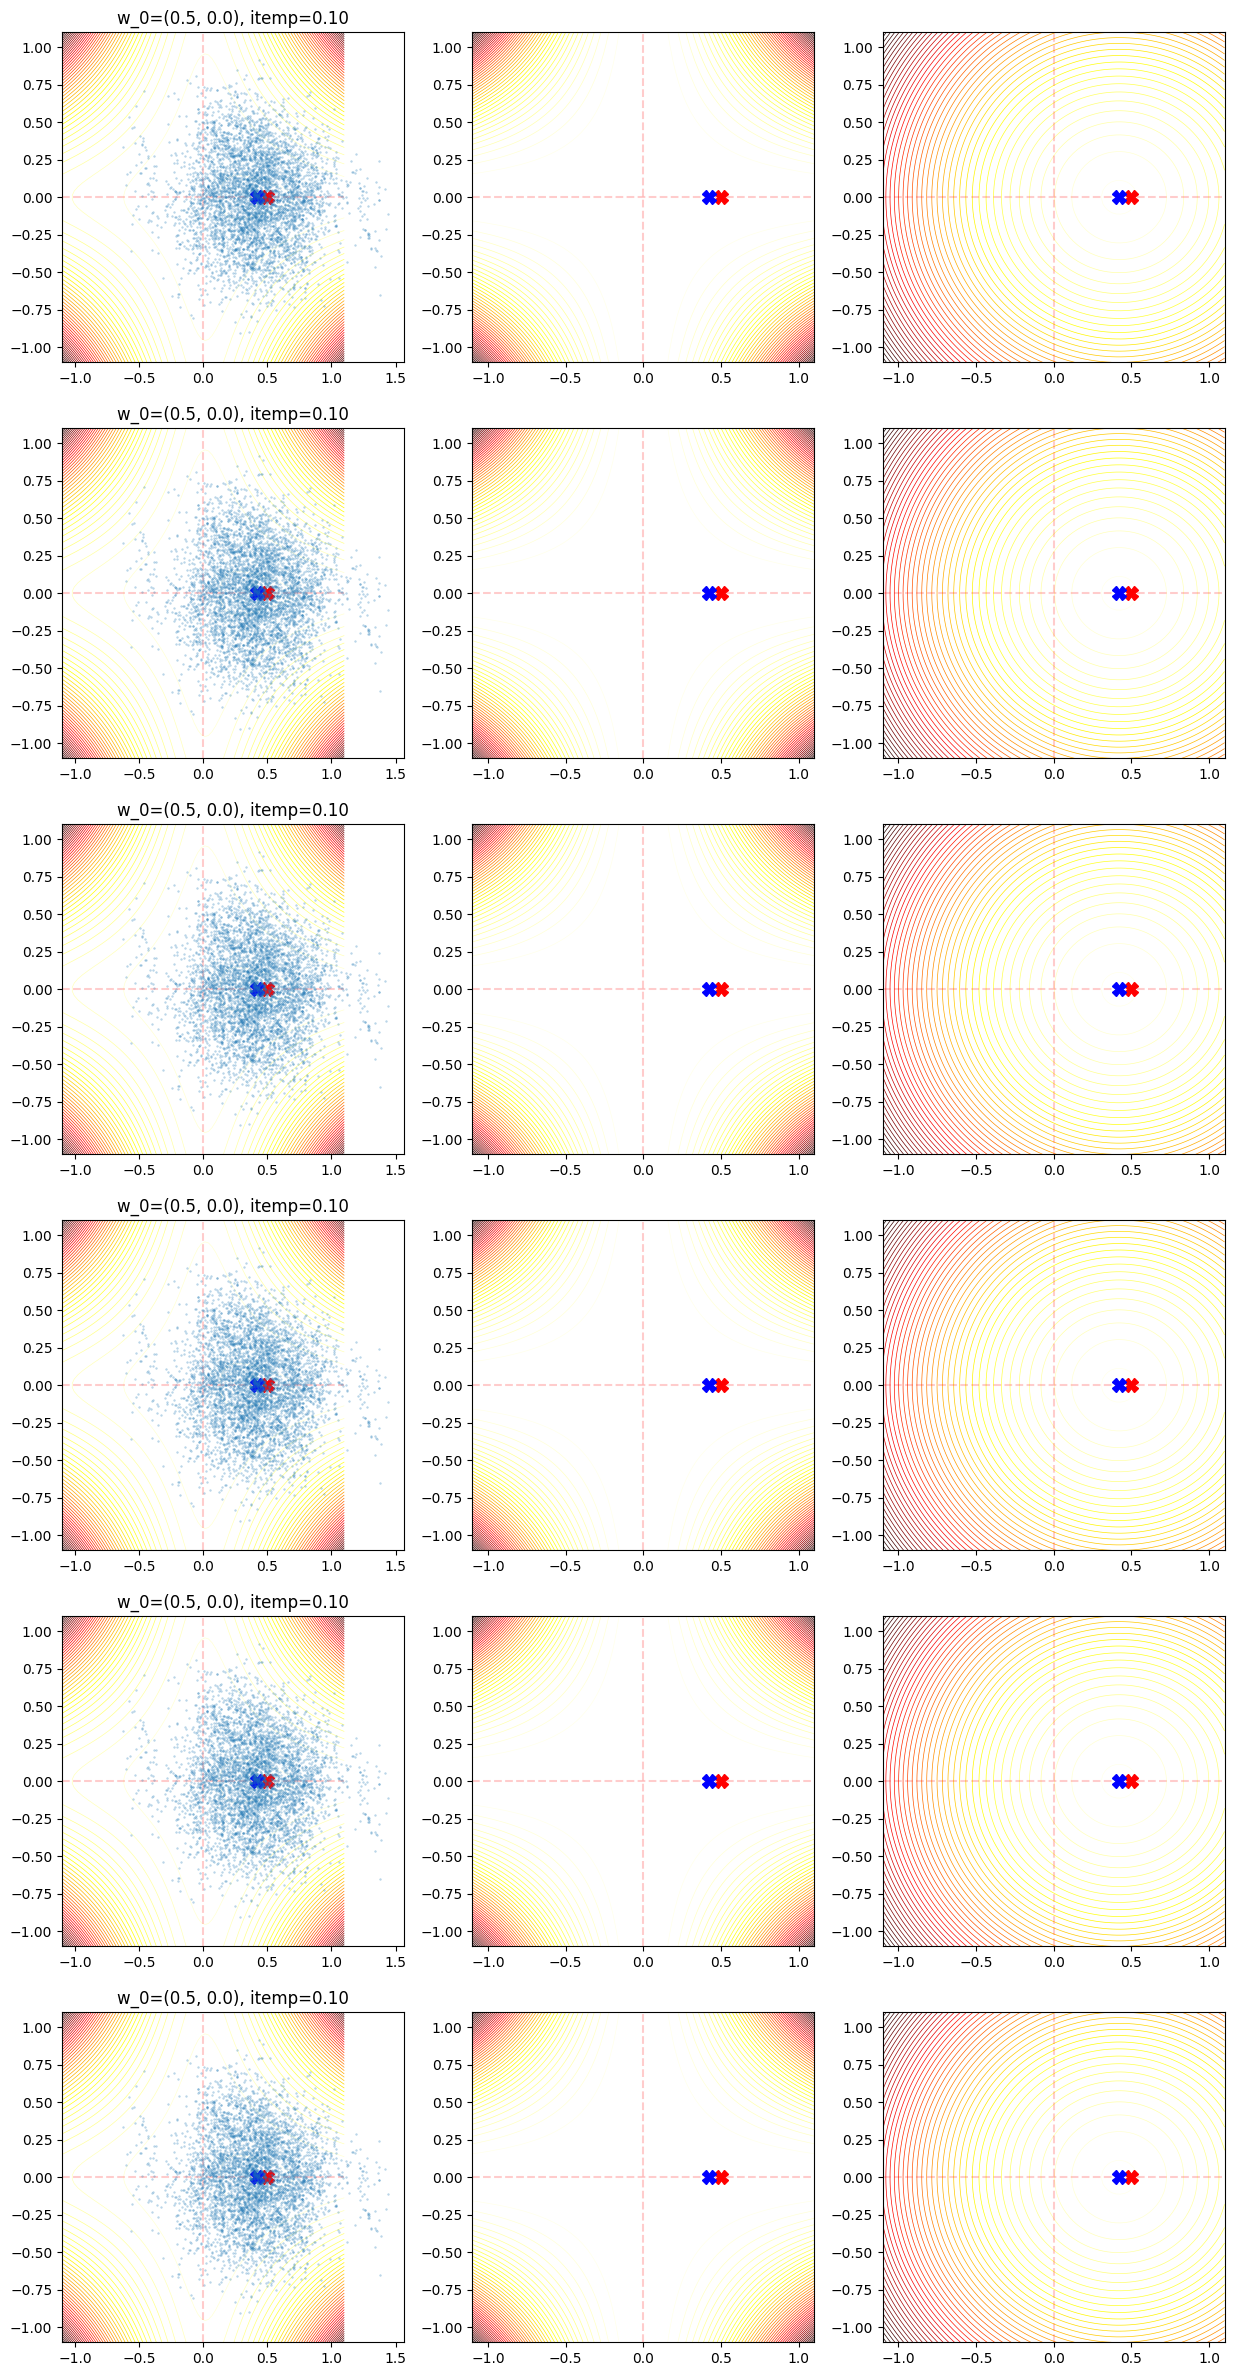

In [8]:
num_rows = len(expt_recs)
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
low, high = -1.1, 1.1
xmin, xmax = low, high
ymin, ymax = low, high
# win_size = 0.1
# a = params_init.detach().numpy()
# xmin, xmax = a[0] - win_size, a[0] + win_size
# ymin, ymax = a[1] - win_size, a[1] + win_size
w1_axis = np.linspace(xmin, xmax, num=80)
w2_axis = np.linspace(ymin, ymax, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)


for row, (itemp, rec) in enumerate(expt_recs.items()):
    with torch.no_grad():
        num_rows, num_cols = W1.shape
        Z = np.zeros_like(W1)
        for func, ax in zip([log_prob_func, log_likelihood_func, log_prior_func], axes[row]):
            for i in range(num_rows):
                for j in range(num_cols):
                    Z[i, j] = func(torch.tensor([W1[i, j], W2[i, j]], dtype=torch.float))
            ax.contour(W1, W2, -Z, levels=50, alpha=1, linewidths=0.5, cmap="hot_r")
            ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
            ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dashed", color="red", alpha=0.2)
            ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dashed", color="red", alpha=0.2)
            ax.plot([param_final[0]], [param_final[1]], "bX", markersize=10)

    ax = axes[row][0]
    for itemp in expt_recs.keys():
        t = torch.stack(expt_recs[itemp]["params"])
        ax.plot(
            t[:, 0], 
            t[:, 1], 
            linewidth=0, 
            marker="+", 
            markersize=1, 
            alpha=0.3, 
            label=f"itemp={itemp:.2f}"
        )
        
    
    ax.set_title(f"w_0={param_true}, itemp={itemp:.2f}");

0.10, 0.50, 0.90, 2.00, 3.00, 4.00, 

Text(0.5, 1.0, 'slope=277.21654647096346, intercept=10415.154084506194')

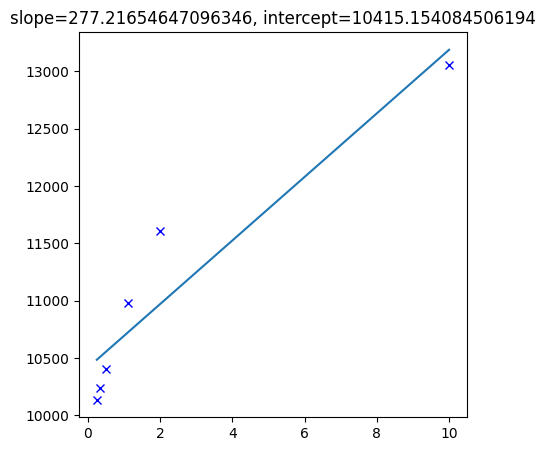

In [9]:
expected_nlns = []
temps = []

for itemp, rec in expt_recs.items():
    print(f"{itemp:.2f}", end=", ")
    params_hmc = rec["params"]
    pred_list, log_prob_list = hamiltorch.predict_model(
        model, 
        x=X_train, 
        y=y_train, 
        samples=params_hmc, 
        model_loss=loss_fn,
    )
    rec["pred_list"] = pred_list
    rec["log_prob_list"] = log_prob_list
    
    expected_nlns.append(-torch.stack(log_prob_list).sum())
    temps.append(1 / itemp)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.array(temps), expected_nlns, "bx")
slope, intercept, r_val, _, _ = scipy.stats.linregress(temps, expected_nlns)
ax.plot(temps, np.array(temps) * slope + intercept)
ax.set_title(f"slope={slope}, intercept={intercept}")